In [1]:
import os
import random
import time
from typing import Tuple, Iterator

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from config import Config
import common
import custom

2024-08-06 07:33:47.558424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 07:33:47.558492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 07:33:47.603427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 07:33:47.693814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 07:33:48.768861: W tensorflow/compiler/tf2

In [2]:
model = custom.models.SiameseModel()
model.load_weights("checkpoints/ckpt_71")

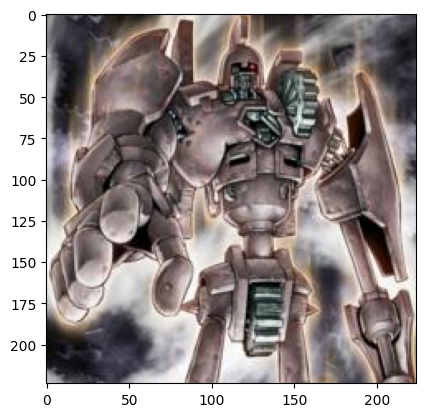

In [3]:
data1 = common.load_image_to_tensor("../card_images_cropped_224/83104731.jpg")
plt.imshow(np.array(data1.numpy(), dtype=np.uint8))
data1 = common.preprocessing(data1)

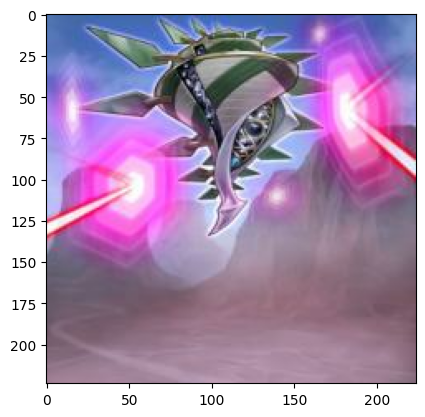

In [4]:
data2 = common.load_image_to_tensor("../card_images_cropped_224/90885155.jpg")
plt.imshow(np.array(data2, dtype=np.uint8))
data2 = common.preprocessing(data2)

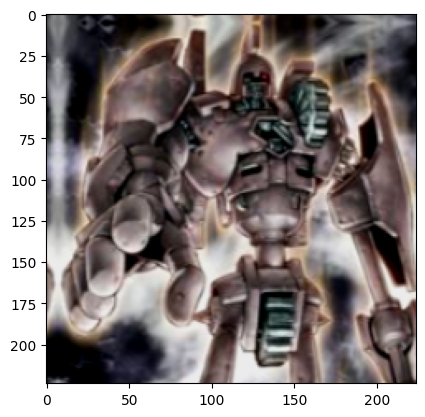

In [5]:
data3 = common.augmentation(data1)
plt.imshow(np.array(data3 * 255, dtype=np.uint8))

In [6]:
pred1 = model(tf.expand_dims(data1, axis=0))
pred2 = model(tf.expand_dims(data2, axis=0))
pred3 = model(tf.expand_dims(data3, axis=0))

2024-08-06 07:34:02.854475: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


In [7]:
custom.losses.triplet_loss(pred1, pred3, pred2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [8]:
distance = tf.math.reduce_sum(tf.math.square(pred1 - pred3), axis=-1)
distance

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.750354], dtype=float32)>

In [9]:
distance = tf.math.reduce_sum(tf.math.square(pred2 - pred3), axis=-1)
distance

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([31.846066], dtype=float32)>

In [10]:
image_path = common.extract_images(f"../{Config.IMAGE_PATH}")
id_list = list(map(common.get_filename, image_path))

dataset = tf.data.Dataset.from_tensor_slices(image_path)
dataset = dataset.map(common.load_image_to_tensor, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(common.preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
matrix = []
for data in dataset.batch(32):
    pred = model(data)
    matrix.append(pred)
matrix = tf.concat(matrix, axis=0)

In [12]:
matrix.shape

TensorShape([13126, 256])

In [13]:
custom.losses.square_norm(pred1, pred3)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.750354], dtype=float32)>

In [14]:
custom.losses.square_norm(pred1, pred2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([23.625607], dtype=float32)>

In [17]:
result = tf.math.reduce_sum(tf.math.square(matrix - pred3), axis=-1)
result = result.numpy()
argsort = np.argsort(result)

In [18]:
for index in argsort[:1000]:
    print(image_path[index], result[index])

../card_images_cropped/44094981.jpg 0.5534836
../card_images_cropped/38273745.jpg 0.70661783
../card_images_cropped/61802346.jpg 0.8112234
../card_images_cropped/83550869.jpg 0.85833305
../card_images_cropped/69764158.jpg 0.87046266
../card_images_cropped/86993168.jpg 1.010535
../card_images_cropped/1295442.jpg 1.0331008
../card_images_cropped/64104037.jpg 1.1071866
../card_images_cropped/79844764.jpg 1.215179
../card_images_cropped/33202303.jpg 1.220249
../card_images_cropped/64964750.jpg 1.22908
../card_images_cropped/76305638.jpg 1.2387171
../card_images_cropped/30113682.jpg 1.2447929
../card_images_cropped/76830505.jpg 1.2523143
../card_images_cropped/76587747.jpg 1.2696661
../card_images_cropped/12143771.jpg 1.3241816
../card_images_cropped/73040500.jpg 1.3445444
../card_images_cropped/2815176.jpg 1.356488
../card_images_cropped/66675911.jpg 1.3598862
../card_images_cropped/68406755.jpg 1.3706425
../card_images_cropped/52543404.jpg 1.38508
../card_images_cropped/95793022.jpg 1.398